In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten,BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  classification_report

import cv2


## Load Data 
### CIFAR 10
### more about dataset https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.2

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 40000
Validation data samples: 10000
Test data samples: 10000


In [4]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
print(new_x_train.shape, new_y_train.shape, x_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000, 1) (10000, 32, 32, 3) (10000, 1)


## Visualize CIFAR 10

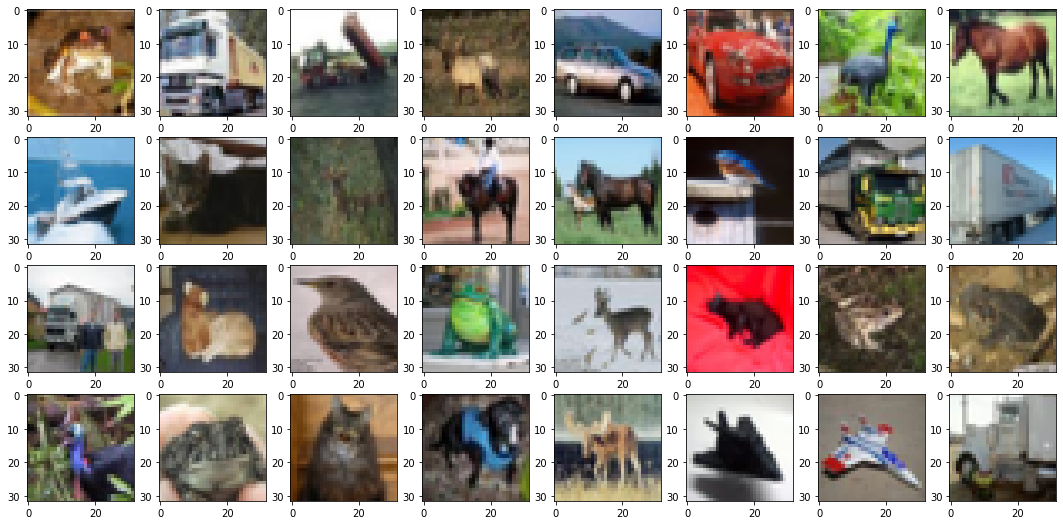

In [6]:
# for plotting
fig = plt.figure(0)
fig.set_size_inches(18.5, 18.5)
for i in range(0,32):
    fig.add_subplot(8, 8, i+1)
    plt.imshow(x_train[i])

## Analyze


In [7]:
cifar10_classes ={
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)

[0 1 2 3 4 5 6 7 8 9]


In [9]:
# percentage of images within each class
print(counts/np.sum(counts)*100)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## Model Building

### Hyperparameters

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

In [11]:
IMAGE_SIZE = 32
auto = tf.data.AUTOTUNE

data_augmentation = keras.Sequential(
    [layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE), layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train.reshape(-1), is_train=True)
val_dataset = make_datasets(x_val, y_val.reshape(-1))
test_dataset = make_datasets(x_test, y_test.reshape(-1))

### Architecture

In [12]:
kernel_size = 3
stride=1
padding=1
pool_size= (2,2)
dropout_conv = 0.2
dropout_dense = 0.2

model = Sequential()

#Layer1
model.add(Conv2D(64, kernel_size,strides=1, activation = 'relu', 
                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization(momentum=0.15, axis=-1))
model.add(Conv2D(64, kernel_size, activation = 'relu', 
                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization(momentum=0.15, axis=-1))
model.add(MaxPooling2D(pool_size = pool_size, strides=2)) 

#Layer2
model.add(Conv2D(128, kernel_size,strides=1, activation = 'relu', 
                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization(momentum=0.15, axis=-1))
model.add(Conv2D(128, kernel_size, activation = 'relu', 
                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization(momentum=0.15, axis=-1))
model.add(MaxPooling2D(pool_size = pool_size, strides=2)) 

#Layer3
model.add(Conv2D(64, kernel_size,strides=1, activation = 'relu', 
                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))) 
model.add(BatchNormalization(momentum=0.15, axis=-1))
model.add(Conv2D(64, kernel_size, activation = 'relu', 
                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization(momentum=0.15, axis=-1))
model.add(MaxPooling2D(pool_size=(1,1), strides=1))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                        

### optimizer

In [13]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


### train

In [14]:
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
)



Epoch 1/10
313/313 [==============================] - 34s 88ms/step - loss: 1.4083 - accuracy: 0.4863 - val_loss: 1.0450 - val_accuracy: 0.6246
Epoch 2/10
313/313 [==============================] - 17s 55ms/step - loss: 0.9380 - accuracy: 0.6670 - val_loss: 0.8683 - val_accuracy: 0.6974
Epoch 3/10
313/313 [==============================] - 17s 54ms/step - loss: 0.7748 - accuracy: 0.7270 - val_loss: 0.7687 - val_accuracy: 0.7360
Epoch 4/10
313/313 [==============================] - 17s 54ms/step - loss: 0.6716 - accuracy: 0.7694 - val_loss: 0.7184 - val_accuracy: 0.7562
Epoch 5/10
313/313 [==============================] - 18s 58ms/step - loss: 0.5946 - accuracy: 0.7937 - val_loss: 0.6881 - val_accuracy: 0.7642
Epoch 6/10
313/313 [==============================] - 17s 53ms/step - loss: 0.5354 - accuracy: 0.8167 - val_loss: 0.6426 - val_accuracy: 0.7822
Epoch 7/10
313/313 [==============================] - 17s 53ms/step - loss: 0.4842 - accuracy: 0.8334 - val_loss: 0.5943 - val_accuracy:

<Figure size 432x288 with 0 Axes>

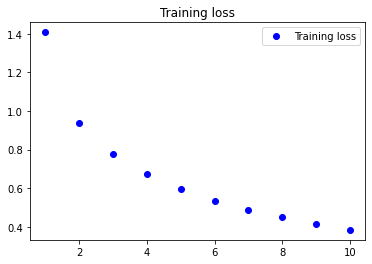

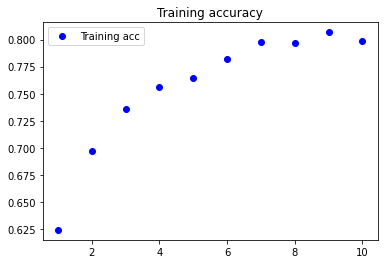

<Figure size 432x288 with 0 Axes>

In [15]:
acc = history.history['val_accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

In [16]:
model.load_weights(checkpoint_filepath)
_, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

79/79 [==============================] - 1s 8ms/step - loss: 0.6193 - accuracy: 0.7986
Test accuracy: 79.86%


In [17]:
# make a prediction
predictions=np.argmax(model.predict(x_test),axis=1)

313/313 [==============================] - 1s 2ms/step


In [18]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoder.transform(y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 8, 8, ..., 5, 1, 7])

In [19]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

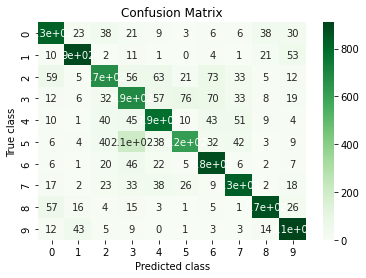

<Figure size 1280x800 with 0 Axes>

In [20]:

abbreviation = ['0','1','2','3','4','5','6','7','8', '9']
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
figure(figsize=(16, 10), dpi=80)
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [21]:
accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7986

In [22]:
print(classification_report(encoder.transform(y_test), predictions))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.90      0.90      0.90      1000
           2       0.77      0.67      0.72      1000
           3       0.61      0.69      0.64      1000
           4       0.77      0.79      0.78      1000
           5       0.81      0.62      0.70      1000
           6       0.78      0.89      0.83      1000
           7       0.83      0.83      0.83      1000
           8       0.90      0.87      0.88      1000
           9       0.84      0.91      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Lets check out an example

In [32]:
def im_resize(im):
    im = cv2.resize(im, (32, 32))
    return im

def print_results(predictions):
  unique, counts = np.unique(predictions, return_counts=True)
  sums = np.sum(counts)
  results = { cifar10_classes[i[0]] : ((i[1]/sums)*100) for i  in zip(unique, counts)}
  print(results)

(1400, 2141, 3)
(1, 32, 32, 3)
1/1 [==============================] - 0s 19ms/step
{'cat': 100.0}


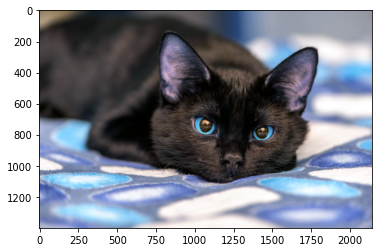

In [33]:
#Load image 
img = cv2.imread("/content/GettyImages-1175550351.jpg", cv2.IMREAD_COLOR) 
plt.imshow(img)

#shape of cat
print(img.shape)

img = im_resize(img)
#Convert to tensor
a = tf.expand_dims(tf.convert_to_tensor(img, dtype=tf.float32), axis=0)
print(a.shape) 

predictions=np.argmax(model.predict(a),axis=1)
print_results(predictions)


(480, 640, 3)
(1, 32, 32, 3)
1/1 [==============================] - 0s 16ms/step
{'automobile': 100.0}


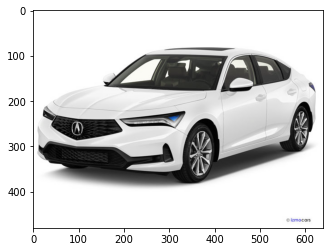

In [29]:
#Load image 
img = cv2.imread("/content/GettyImages-1175550352.jpg", cv2.IMREAD_COLOR) 
plt.imshow(img)

#shape of cat
print(img.shape)

img = im_resize(img)
#Convert to tensor
a = tf.expand_dims(tf.convert_to_tensor(img, dtype=tf.float32), axis=0)
print(a.shape) 

predictions=np.argmax(model.predict(a),axis=1)
print_results(predictions)